# CLIP과의 상호작용

CLIP 모델을 다운로드 및 실행하고, 임의 이미지와 텍스트 입력 간의 유사성을 계산하고, 제로샷 이미지 분류를 수행하는 방법을 보여줍니다.

### Colab 에서 실행

ftfy는 "fixes text for you"의 약자로, 텍스트 데이터를 깔끔하게 정리해주는 Python 라이브러리

In [2]:
! pip install -q ftfy regex tqdm
# GitHub에서 openai의 CLIP 리포지토리를 직접 설치
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jangz9c_
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jangz9c_
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=33bbffa4ffa7d68cc7790baf528d396fe2d77f5c393cf0b609a6931d0f9f2dac
  Stored in directory: /tmp/pip-ephem-wheel-cache-yqyo2m2_/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import numpy as np
import torch
#from pkg_resources import packaging
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict

# 모델 로딩

`clip.available_models()` : 사용 가능한 CLIP 모델의 이름을 나열

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
# CLIP의 모델 아키텍처를 지정 및 전처리 함수 로드
model, preprocess = clip.load("ViT-B/32")

# 모델을 GPU로 옮기고 평가 모드로 설정
model.cuda().eval()

# CLIP 모델의 입력 해상도, 문맥 길이, 어휘 크기 정보를 가져와 출력
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


Input resolution: 224
Context length: 77
Vocab size: 49408


In [6]:
# CLIP 모델의 파라미터 수를 계산하여 출력
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Model parameters: 151,277,313


# 이미지 전처리

모델이 기대하는 이미지 해상도에 맞게 입력 이미지의 크기를 조정하고 가운데 부분을 자릅니다. 그 전에 데이터 세트 평균과 표준 편차를 사용하여 픽셀 강도를 정규화합니다.

`clip.load()`의 두 번째 반환 값에는 이 사전 처리를 수행하는 torchvision `Transform`이 포함되어 있습니다.



In [7]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7c2a79b612d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# 텍스트 전처리

`clip.tokenize()`를 사용하여 대소문자를 구분하지 않는 토크나이저를 사용합니다. 기본적으로 출력은 77개의 토큰 길이가 되도록 채워지며, 이는 CLIP 모델이 예상하는 것입니다.

In [8]:
tokenized_text = clip.tokenize("Hello World!")
print(tokenized_text.shape)
tokenized_text

torch.Size([1, 77])


tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# 입력 이미지 및 텍스트 설정

8개의 예시 이미지와 해당 텍스트 설명을 모델에 제공하고 해당 feature 간의 유사성을 비교할 것입니다.

토크나이저는 대소문자를 구분하지 않으며 적절한 텍스트 설명을 자유롭게 제공할 수 있습니다.

In [9]:
# skimage 내의 이미지들을 prompt engineering 하여 저장
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

In [10]:
skimage.data_dir

'/root/.cache/scikit-image/0.19.3/data'

In [11]:
file_names = [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]
file_names[:5]

['grass.png', 'logo.png', 'moon.png', 'astronaut.png', 'hubble_deep_field.jpg']

In [12]:
# 파일명에서 확장자를 제거하여 이미지의 이름을 얻습니다.
os.path.splitext(file_names[0])[0]

'grass'

In [13]:
# 원본 이미지와 처리된 이미지, 그리고 텍스트를 저장하기 위한 리스트를 초기화
original_images = []
preprocessed_images = []
texts = []

# skimage의 데이터 디렉토리에서 .png 또는 .jpg로 끝나는 모든 파일을 반복 처리
for filename in file_names:
    name = os.path.splitext(filename)[0]

    # descriptions dictionary에 없는 이미지는 무시
    if name not in descriptions:
        continue

    # 이미지를 열어 공통적으로 RGB 포맷 변환
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    original_images.append(image)  # 원본이미지
    preprocessed_images.append(preprocess(image))  # 전처리된 이미지
    texts.append(descriptions[name])   # prompt 화 된 이미지 설명

len(original_images), len(preprocessed_images), len(texts)

(8, 8, 8)

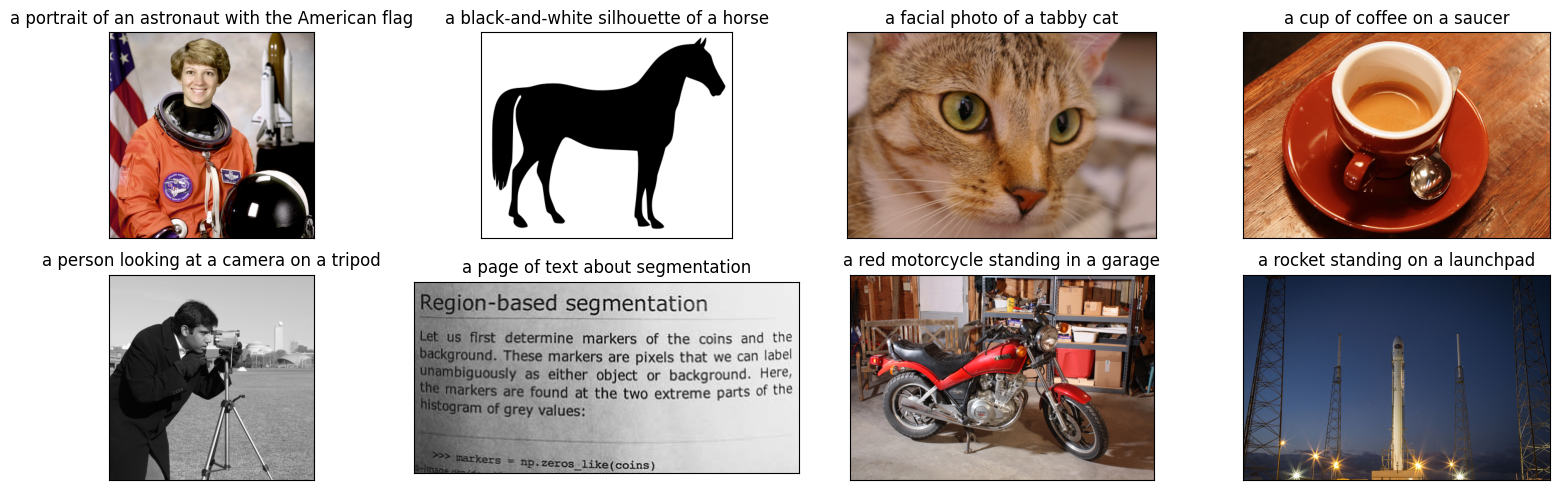

In [14]:
 # 처리된 이미지 시각화
plt.figure(figsize=(16, 5))
for i, image in enumerate(original_images):
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"{texts[i]}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

## feature 생성

이미지를 정규화하고, 각 텍스트 입력을 토큰화하고, 모델의 순방향 전파를 실행하여 이미지와 텍스트 feature를 얻습니다.

In [15]:
# 이미지 리스트를 numpy 배열로 변환한 후, 이를 파이토치 텐서로 변환후 GPU로 전송
image_input = torch.tensor(np.stack(preprocessed_images)).cuda()

# 이미지에 대한 설명들 앞에 "This is "를 추가한 후, CLIP의 tokenize 함수를 사용하여 텍스트 토큰을 생성
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
text_tokens[0]

tensor([49406,   589,   533,   320,  5352,   539,   550, 18376,   593,   518,
         2151,  4859, 49407,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0], device='cuda:0',
       dtype=torch.int32)

### CLIP의 model에서 Image Feature 와 Text Feature 추출

In [16]:
with torch.no_grad():
    # 이미지 입력을 모델에 전달하여 이미지 특성을 추출
    image_features = model.encode_image(image_input).float()

    # 텍스트 토큰을 모델에 전달하여 텍스트 특성을 추출
    text_features = model.encode_text(text_tokens).float()

image_features.shape, text_features.shape

(torch.Size([8, 512]), torch.Size([8, 512]))

## 코사인 유사도 계산

feature를 정규화하고 각 쌍의 내적을 계산합니다.

In [17]:
# 이미지/text 특성의 L2 Norm(유클리드 노름)을 계산하여 특성 벡터를 정규화
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# 텍스트 특성과 이미지 특성 사이의 유사성을 계산하기 위해 내적(dot product) 연산을 수행
# 결과적으로, 이 유사성 행렬의 각 element는 특정 텍스트 설명과 이미지 간의 유사성 score를 나타냅니다.
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

image_features.shape, text_features.shape, similarity.shape

(torch.Size([8, 512]), torch.Size([8, 512]), (8, 8))

In [19]:
similarity.min(), similarity.max()

(0.11465831, 0.35393128)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

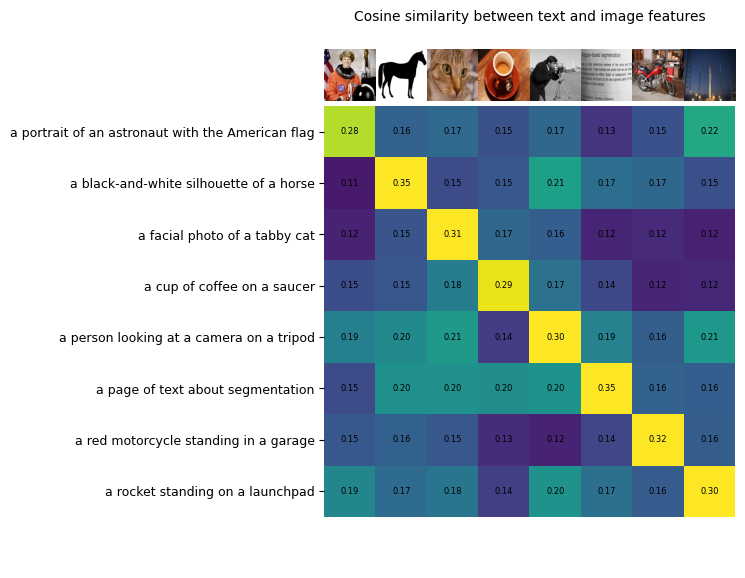

In [37]:
count = len(descriptions)

plt.figure(figsize=(10, 7))

# 이미지와 텍스트 사이의 코사인 유사도를 표시
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=9)   #yticks에 description 표시
plt.xticks([])

# 각 이미지가 위로 표시
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# 유사도 매트릭스의 각 셀에 해당하는 값을 표시
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=6)

# 그래프 주변의 테두리 제거
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# x축과 y축의 범위 설정
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# 그래프 제목 설정
plt.title("Cosine similarity between text and image features", size=10)